In [4]:
from senticnet.senticnet import SenticNet
import nltk
from tqdm import tqdm
import xlrd
import pandas as pd
import random
from textblob import TextBlob
import numpy as np
import IPython
import re
from nltk.corpus import stopwords
import json
import inflection as inf
from wordcloud import WordCloud
from gensim.models import Word2Vec
import enchant
import time
from nltk import sent_tokenize

# import matplotlib.pyplot as plt

adj = ['JJ','JJR','JJS']
adv = ['RB','RBR','RBS']
vb = ['VB','VBD','VBG','VBN','VBP','VBZ']
nn = ['NN','NNS']


def review_to_words(review_text): 
    if '(Reuters) -' in review_text:
        review_text = review_text.split('(Reuters) -')[1]
    if '*' in review_text:
        review_text = review_text.split('*')[1]
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    words = letters_only.split()                             
    _stopwords = set(stopwords.words("english"))
    _stopwords = nltk.corpus.stopwords.words('english')
    _stopwords.append('would')
    _stopwords.append('kmh')
    _stopwords.append('mph')
    _stopwords.append('  ')
    _stopwords.append('Reuters')
    _stopwords.append('reuters')
    # _stopwords = []
    meaningful_words = [w for w in words if w not in _stopwords]
    return meaningful_words

# d = enchant.Dict("en_US")
import spacy
nlp = spacy.load('en')
def stem_and_check(word):
    word = nlp(word)
    return word[0].lemma_
    # word = inf.singularize(word)
    # word = nltk.PorterStemmer().stem(word)
    # if d.check(word):
    #    return word
    # suggest_words = d.suggest(word)
    # if len(suggest_words) == 0:
    #    return word
    # return suggest_words[0]

def my_read(path):
    file = open(path)
    words = []
    for line in file.readlines():
        words.append(line.strip())
    return words

def output_cloud(count,name):
    # 云图
    text = '' 
    for key,value in count.items():
        text += (key+' ') * (value)
    wc = WordCloud(
        width=1000,
        height=600,
        max_font_size=100,      #字体大小
        min_font_size=10,
        collocations=False, 
        max_words=1000
    )
    wc.generate(text)
    wc.to_file(name+'.png') #图片保存

sn = SenticNet()
# concept_info = sn.concept('love')
# polarity_value = sn.polarity_value('love')
# polarity_intense = sn.polarity_intense('love')
# moodtags = sn.moodtags('love')
# semantics = sn.semantics('love')
# sentics = sn.sentics('love') 
 
def sentiment_score(text):
    t = TextBlob(text)
    score = t.sentiment.polarity
    return score
    # tokens = nltk.word_tokenize(text)
    # pos_tags = nltk.pos_tag(tokens)
    # score = 0
    # count = 0
    # for word,tag in pos_tags:
    #   if word in sn.data.keys():
    #    score += float(sn.polarity_intense(word))
    #    count += 1
    #    # print(word,sn.polarity_intense(word))
    # if count == 0: #mid
    #   return -1 
    # return score/count


In [5]:
# test sentiment_score accuracy
# scores = []
# workbook = pd.read_csv(u'sentiment.csv',encoding='ISO-8859-1')
# correct = 0
# pos_count = 0
# neg_count = 0
# pos_correct = 0
# neg_correct = 0

# for i in tqdm(range(0,10000)):
#   i = int(random.random()*1599999)
#   if workbook.loc[i][0] == 0:
#    neg_count += 1
#    if workbook.loc[i][0] == sentiment_score_list(workbook.loc[i][5]):
#     neg_correct += 1
#   elif workbook.loc[i][0] == 4:
#    pos_count += 1
#    if workbook.loc[i][0] == sentiment_score_list(workbook.loc[i][5]):
#     pos_correct += 1
# print('pos',pos_correct/pos_count,pos_count,pos_correct)
# print('neg',neg_correct/neg_count,neg_count,neg_correct)


In [6]:
path = r'Desktop/Dynamic-Financial-News-Collection-and-Analysis/data/labeled_data.xls'

workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_index(0)
contents = worksheet.col_values(1)
companies = worksheet.col_values(2)
prices = worksheet.col_values(3)
dates = worksheet.col_values(4)
rates = []
score_list = []

In [7]:
# for i in tqdm(range(0,len(contents))):
#    rate = []
#    price_list = json.loads(prices[i])
#    for idx in range(0,6):
#       rate.append((price_list[idx+1]-price_list[idx])/price_list[idx])
#    rates.append(rate)
#    score_list.append(sentiment_score(contents[i]))

# # 情感极性与六天内（包括）新闻涨跌比率的相关度
# # fiveday_rate_list = []
# for i in range(0,6):
#    rate = [x[i] for x in rates]
#    data = {
#         'scores':score_list,
#         'rates':rate
#         }

#    df = pd.DataFrame(data)
#    # print(df)
#    print(df.corr("kendall"))

In [12]:
datas = []
for i in tqdm(range(0,len(contents))):
    # if '*' not in contents[i]:
        # if companies[i] != 'Apple Inc.':
        #     continue
    data = {}
    data['content'] = contents[i]
    sents = sent_tokenize(data['content'])
    data['tokens'] = []
    data['tags'] = []
    for sent in sents:
        token = review_to_words(sent) # 去停用词会影响词性标注吗？？
        data['tokens'].append(token)
        data['tags'].append(nltk.pos_tag(token))
    data['company'] = companies[i]
    price_list = json.loads(prices[i])       
    data['rate'] = (price_list[1]-price_list[0])/price_list[0]
    data['date'] = dates[i]
    datas.append(data)

100%|██████████| 20961/20961 [13:00<00:00, 17.59it/s]


In [13]:
## sort by time
# dates = {}
# for i in tqdm(range(0,len(_datas))):
#     dates[i] = int(time.mktime(time.strptime(_datas[i]['date'], "%Y-%m-%d")))
# res = sorted(dates.items(),key=lambda dates:dates[1],reverse=False)
# datas = []
# for idx,date in res:
#     datas.append(_datas[idx])


In [14]:
count = {}

POS = 0
NEG = 0

pos_count = 0
neg_count = 0

N = 0 #len of tokens


for data in tqdm(datas):
    for tokens in data['tokens']: 
        N += len(tokens)
        rate = data['rate'] # 选当天的股票变化判断涨跌，因为相关度当天的最高
        if rate>0:
            pos_count += 1
            POS += len(tokens)
            for token in tokens:
                if len(token) < 3:
                    continue
                if 'not' in tokens:
                    token = 'not_'+token
                if token in count.keys():
                    count[token]['pos'] += 1
                    count[token]['pos_rate'] += rate
                else:
                    count[token] = {'pos':1,'neg':0,'pos_rate':rate,'neg_rate':0} 

        if rate<0:
            neg_count += 1
            NEG += len(tokens)
            for token in tokens:
                if len(token) < 3:
                    continue
                if 'not' in tokens:
                    token = 'not_'+token
                if token in count.keys():
                    count[token]['neg'] += 1
                    count[token]['neg_rate'] -= rate
                else:
                    count[token] = {'pos':0,'neg':1,'pos_rate':0,'neg_rate':-rate}


100%|██████████| 20961/20961 [00:07<00:00, 2928.05it/s]


In [15]:
## freq
copy = count.copy()
sent_words = [] # PD>0.3情感值

freq_pos = pos_count/len(datas) 
freq_neg = neg_count/len(datas)

# DS sent and PMI sent
for word,value in tqdm(copy.items()):
    if value['pos']+value['neg']<20:
        del count[word]
        continue
    freq_w_pos = value['pos']/len(datas)
    freq_w_neg = value['neg']/len(datas)
    freq_w = (value['pos']+value['neg'])/len(datas)
    if freq_w_pos*N == 0:
        PMI_w_pos = 0
    else:
        PMI_w_pos = np.log2(freq_w_pos*N/freq_w*freq_pos)
    if freq_w_neg*N == 0:
        PMI_w_neg = 0
    else:
        PMI_w_neg = np.log2(freq_w_neg*N/freq_w*freq_neg)
    count[word]['PMI_sent'] = PMI_w_pos - PMI_w_neg

    pos = value['pos']/len(datas)
    neg = value['neg']/len(datas)
    value['PD'] = (pos-neg)/(pos+neg) # polarity difference
    if abs(value['PD']) > 0.3 and nltk.pos_tag([word])[0][1] in adj+adv:  
        sent_words.append(word)
    count[word]['sent'] = value['PD']*value['PD'] * np.sign(value['PD'])

    pos_rate = value['pos_rate']/len(datas)
    neg_rate = value['neg_rate']/len(datas)
    value['PD_rate'] = (pos_rate-neg_rate)/(pos_rate+neg_rate) # polarity difference
    count[word]['sent_rate'] = value['PD_rate']*value['PD_rate'] * np.sign(value['PD_rate'])


100%|██████████| 59369/59369 [00:00<00:00, 84763.08it/s]


In [16]:
# res = sorted(sent_words.items(),key=lambda sent_words:sent_words[1],reverse=False)
res = sorted(count.items(),key=lambda count:count[1]['sent'],reverse=False)
for r in res[:100]:
    print(r[0],r[1]['sent'])
res = sorted(count.items(),key=lambda count:count[1]['sent'],reverse=True)  
for r in res[:100]:
    print(r[0],r[1]['sent'])
# res = sorted(count.items(),key=lambda count:count[1]['PD'],reverse=True)
# print(res)

Marakby -1.0
Amtrak -1.0
Qantas -1.0
SoFi -1.0
ArcSight -1.0
FSTEC -1.0
Callidus -1.0
Ghosn -1.0
IOC -1.0
rats -1.0
Iancu -1.0
Mtpa -1.0
Venucia -1.0
Seki -1.0
Eylea -1.0
Schleifer -1.0
Gateway -1.0
Ciarallo -1.0
UOL -1.0
Nexa -1.0
Netshoes -1.0
FACT -1.0
TCH -1.0
BlackBerry -1.0
Ying -1.0
Tenable -1.0
Chromebooks -1.0
Breland -1.0
CAAM -1.0
heists -1.0
PCTCHNG -1.0
NETCHNG -1.0
TRDPRC -1.0
Chewy -1.0
Arco -1.0
Cordis -1.0
SoCalGas -1.0
Karani -1.0
Multichoice -1.0
Zoom -1.0
Wasp -1.0
KIPCO -1.0
OSN -1.0
Kubasik -0.9534948096885812
SandRidge -0.9149338374291116
pea -0.9000657462195923
Man -0.8711111111111112
Denali -0.8668252080856124
Morneau -0.8668252080856124
Accor -0.8622448979591836
herbicides -0.8573388203017833
Burnaby -0.8520710059171597
Shaheen -0.8520710059171597
Madness -0.8520710059171597
Noto -0.8402777777777777
Livent -0.8402777777777777
Aliso -0.8336483931947068
AIA -0.8336483931947068
artist -0.8264462809917354
Klepierre -0.8264462809917354
AccorHotels -0.81859410430839

In [17]:
## neg pos 词
# pos_words = {}
# neg_words = {}
# for word in sent_words:
#    if count[word]['sent'] > 0:
#       pos_words[word.lower()] = count[word]['pos']+count[word]['neg']
#    else:
#       neg_words[word.lower()] = count[word]['pos']+count[word]['neg']

# output_cloud(pos_words,'pos')
# output_cloud(neg_words,'neg')

In [22]:
## 求于bl词典的覆盖率
bl_sent = {}
bl_pos = my_read('Desktop/Dynamic-Financial-News-Collection-and-Analysis/sentiment_analysis/bl/positive.txt')  # 4783
bl_neg = my_read('Desktop/Dynamic-Financial-News-Collection-and-Analysis/sentiment_analysis/bl/negative.txt')  # 2006

for word in bl_pos:
    bl_sent[word] = 1
for word in bl_pos:
    bl_sent[word] = -1
# pc = 0
# for word in pos_words:
#    if word in bl_pos:
#       pc += 1
# pos_accuracy = pc/len(pos_words)  # 0.2857142857142857

# nc = 0
# for word in neg_words:
#    if word in bl_neg:
#       nc += 1
# neg_accuracy = nc/len(neg_words)  # 0.18

In [21]:
## context sentiment dict
sent_words = [word.lower() for word in sent_words]
feature_words = {}
sentiment_feature = {}

for data in tqdm(datas):
    for tags in data['tags']:
        for word,tag in tags:
            if tag not in nn or len(word)<3: # vb+nn
                continue
            # word = stem_and_check(word)
            if word not in feature_words.keys():
                feature_words[word] = 1
            else:
                feature_words[word] += 1

# avg_f = sum([item[1] for item in feature_words.items()])/len(feature_words.keys())
res = sorted(feature_words.items(),key=lambda feature_words:feature_words[1],reverse=True)
words = res[:400]
# for word,value in tqdm(copy.items()):
#     if value<avg_f+200:
#         del feature_words[word]

feature_words = [inf.singularize(word).lower() for word,freq in words]
print(feature_words)

100%|██████████| 20961/20961 [00:01<00:00, 10989.33it/s]

['percent', 'year', 'company', 'market', 'point', 'share', 'trade', 'company', 'week', 'stock', 'index', 'quarter', 'earning', 'investor', 'growth', 'datum', 'month', 'stock', 'price', 'market', 'sale', 'dollar', 'business', 'day', 'profit', 'technology', 'bank', 'sector', 'high', 'year', 'tariff', 'trading', 'time', 'investment', 'rate', 'deadline', 'interest', 'oil', 'deal', 'rate', 'share', 'low', 'report', 'gain', 'government', 'result', 'issue', 'revenue', 'yield', 'maker', 'tax', 'analyst', 'economy', 'firm', 'equity', 'concern', 'price', 'world', 'consumer', 'ratio', 'bank', 'cost', 'inflation', 'bond', 'month', 'estimate', 'record', 'group', 'expectation', 'service', 'com', 'demand', 'sector', 'day', 'policy', 'energy', 'person', 'industry', 'war', 'fund', 'product', 'crude', 'loss', 'debt', 'term', 'news', 'future', 'rise', 'risk', 'comment', 'strategist', 'part', 'session', 'asset', 'analyst', 'currency', 'good', 'talk', 'firm', 'drop', 'yield', 'meeting', 'increase', 'stake'

In [23]:
sf_len = 0
for data in tqdm(datas):
    rate = data['rate']
    for tokens in data['tokens']:
        token_dict = {}
        for token in tokens:
            token_dict[inf.singularize(token).lower()] = token
        _tokens = [inf.singularize(token).lower() for token in tokens]

        for w in list(set(sent_words).intersection(set(_tokens))):
            for f in list(set(feature_words).intersection(set(_tokens))):
                if f != w:
                    if abs(_tokens.index(w)-_tokens.index(f))<3 and ',' not in data['content'][min(data['content'].index(token_dict[f]),data['content'].index(token_dict[w])):max(data['content'].index(token_dict[f]),data['content'].index(token_dict[w]))]:
                        sf_len += 1
                        if f not in sentiment_feature.keys():
                            sentiment_feature[f] = {}
                            if rate > 0:
                                sentiment_feature[f][w] = {'pos':1,'neg':0}
                            if rate < 0:
                                sentiment_feature[f][w] = {'pos':0,'neg':1}
                        else:
                            if w not in sentiment_feature[f].keys():
                                sentiment_feature[f][w] = {'pos':0,'neg':0}
                            if rate > 0:
                                sentiment_feature[f][w]['pos'] += 1
                            if rate < 0:
                                sentiment_feature[f][w]['neg'] += 1

avg_sf = sf_len/len(sentiment_feature.keys())
copy = sentiment_feature.copy()

for f,v in sentiment_feature.items():
    for w,value in v.items():
        if value['pos']+value['neg']<avg_sf: #avg_sf
            # print(f,w,value)
            # del sentiment_feature[f][w]
            sentiment_feature[f][w]['sent'] = 0
            continue
        pos = value['pos']/POS
        neg = value['neg']/NEG
        
        value['PD'] = (pos-neg)/(pos+neg) # polarity difference
        sentiment_feature[f][w]['sent'] = value['PD'] * value['PD'] * np.sign(value['PD'])
print(sentiment_feature)

100%|██████████| 20961/20961 [07:53<00:00, 44.25it/s] 

{'state': {'united': {'pos': 3711, 'neg': 3611, 'PD': -0.014819948321550667, 'sent': -0.00021963086825343246}, 'mostly': {'pos': 4, 'neg': 4, 'sent': 0}, 'midwest': {'pos': 2, 'neg': 1, 'sent': 0}, 'fresh': {'pos': 0, 'neg': 4, 'sent': 0}, 'healthy': {'pos': 0, 'neg': 1, 'sent': 0}, 'political': {'pos': 0, 'neg': 2, 'sent': 0}, 'well': {'pos': 10, 'neg': 8, 'sent': 0}, 'electoral': {'pos': 1, 'neg': 3, 'sent': 0}, 'clean': {'pos': 0, 'neg': 1, 'sent': 0}, 'ally': {'pos': 4, 'neg': 1, 'sent': 0}, 'potential': {'pos': 4, 'neg': 1, 'sent': 0}, 'annual': {'pos': 0, 'neg': 1, 'sent': 0}, 'family': {'pos': 1, 'neg': 1, 'sent': 0}, 'fewest': {'pos': 0, 'neg': 3, 'sent': 0}, 'recreational': {'pos': 5, 'neg': 0, 'sent': 0}, 'active': {'pos': 2, 'neg': 0, 'sent': 0}, 'assembly': {'pos': 1, 'neg': 0, 'sent': 0}, 'generally': {'pos': 0, 'neg': 1, 'sent': 0}, 'later': {'pos': 17, 'neg': 8, 'sent': 0}, 'trilateral': {'pos': 2, 'neg': 3, 'sent': 0}, 'natural': {'pos': 1, 'neg': 0, 'sent': 0}, 'worst'

In [28]:
# 展示
# pos_res = {}
# for r in res:
#     if r[1]['sent'] == 1.0:
#         pos_res[r[0]] = r[1]['pos']+r[1]['neg']
# pos_res = sorted(pos_res.items(),key=lambda pos_res:pos_res[1],reverse=True)
# for r in pos_res[:20]:
#     print(r[0],'1.0',r[1])
#     print(' ')

# print(' ')
# print('========================')
# print(' ')

# neg_res = {}
# for r in res:
#     if r[1]['sent'] == -1.0:
#         neg_res[r[0]] = r[1]['pos']+r[1]['neg']
# neg_res = sorted(neg_res.items(),key=lambda neg_res:neg_res[1],reverse=True)
# for r in neg_res[:20]:
#     print(r[0],'-1.0',r[1])
#     print(' ')
# # for sf,value in sentiment_feature.items():
#    if value['pos']+value['neg'] > avg_sf:
#       print(sf,freq)
# print(res)
for sf in sentiment_feature.keys():
    for word in sentiment_feature[sf].keys():
        if sentiment_feature[sf][word]['pos'] + sentiment_feature[sf][word]['neg'] > 5:
            print(sf,word,sentiment_feature[sf][word]['sent'])

state united -0.00021963086825343246
state mostly 0
state well 0
state later 0
sell united 0
sell potential 0
sell fresh 0
sell natural 0
vote later 0
vote annual 0
year later 0.010568148821700098
year well 0
year united 0
year fresh 0
year positive 0
year worst 0
year annual 0
year active 0
year uninterrupted 0
year maybe 0
year generally 0
year organically 0
year fewest 0
year underwritten 0
pay political 0
pay typically 0
price political 0
price stronger 0
price well 0
price annual 0
price united 0
price later 0
price rather 0
price apart 0
price potential 0
price positive 0
price natural 0
price ugly 0
market natwest 0
market active 0
market positive 0
market united 0
market annual 0
market natural 0
market potential 0
market leveraged 0
market well 0
market unprofitable 0
market rather 0
market mostly 0
market stronger 0
market later 0
market generally 0
market upended 0
market healthy 0
strategy well 0
analyst well 0
analyst generally 0
analyst positive 0
analyst potential 0
anal

development political 0
development well 0
development positive 0
development united 0
crisis political 0
crisis dramatically 0
target potential 0
target annual 0
target elusive 0
activity stronger 0
asset safe 0
asset well 0
asset positive 0
asset urgently 0
volume daily 0
deal later 0
deal potential 0
deal well 0
deal positive 0
deal united 0
deal rather 0
deal daily 0
deal underwritten 0
term positive 0
term well 0
term undisclosed 0
term potential 0
volatility idle 0
volatility potential 0
volatility political 0
volatility stronger 0
power natural 0
power political 0
election annual 0
election political 0
decade later 0
decade uninterrupted 0
rule potential 0
slowdown fresh 0
slowdown potential 0
slowdown united 0
news political 0
news positive 0
news maybe 0
news united 0
news potential 0
news well 0
news fresh 0
beat well 0
beat narrowly 0
beat rather 0
beat typically 0
executive positively 0
inflation stronger 0
inflation annual 0
inflation potential 0
online annual 0
conference

In [29]:
## company word
# company_pos = {}
# company_neg = {}
# for key,value in sentiment_feature.items():
#    if 'company' in key:
#       if sentiment_feature[key]['sent'] > 0:
#          company_pos[key.split('_')[0]] = sentiment_feature[key]['pos']
#       else:
#          company_neg[key.split('_')[0]] = sentiment_feature[key]['neg']

# output_cloud(company_pos,'company_pos')
# output_cloud(company_neg,'company_neg')

In [30]:
# for r in res[:30]:
#    print(r[0],r[1]['sent'],r[1]['pos']+r[1]['neg'])
#    print(' ')

# print(' ')
# print('========================')

# for r in res[-40:]:
#    print(r[0],r[1]['sent'],r[1]['pos'],r[1]['neg'])
#    print(' ')

# 展示
# pos_res = {}
# for r in res:
#     if r[1]['sent'] == 1.0:
#         pos_res[r[0]] = r[1]['pos']+r[1]['neg']
# pos_res = sorted(pos_res.items(),key=lambda pos_res:pos_res[1],reverse=True)
# for r in pos_res[:20]:
#     print(r[0],'1.0',r[1])
#     print(' ')

# print(' ')
# print('========================')
# print(' ')

# neg_res = {}
# for r in res:
#     if r[1]['sent'] == -1.0:
#         neg_res[r[0]] = r[1]['pos']+r[1]['neg']
# neg_res = sorted(neg_res.items(),key=lambda neg_res:neg_res[1],reverse=True)
# for r in neg_res[:20]:
#     print(r[0],'-1.0',r[1])
#     print(' ')
# # for sf,value in sentiment_feature.items():
#    if value['pos']+value['neg'] > avg_sf:
#       print(sf,freq)

In [32]:

# Predict
# content to vector

for data in tqdm(datas):
    idx = datas.index(data)
    tokens = data['tokens']
    datas[idx]['DsVector'] = [0,0,0,0]
    datas[idx]['DsVector_rate'] = [0,0,0,0]
    datas[idx]['SnVector'] = [0,0,0,0]
    datas[idx]['BlVector'] = [0,0,0,0]
    datas[idx]['PmiVector'] = [0,0,0,0]
    datas[idx]['ContextVector'] = [0,0,0,0]
    
    # for f in [token for token in tokens if token in sentiment_feature.keys()]:
    #     for w in sentiment_feature[f].keys():
    #         if w in tokens:
    #             if abs(tokens.index(f)-tokens.index(w))<3 and ',' not in data['content'][min(data['content'].index(f),data['content'].index(w)):max(data['content'].index(f),data['content'].index(w))]:
    #                 if tags[tokens.index(f)][1] in adj:
    #                     if f in count.keys():
    #                         datas[idx]['ContextVector'][0] += count[f]['sent']
    #                 elif tags[tokens.index(f)][1] in adv:
    #                     if f in count.keys():
    #                         datas[idx]['ContextVector'][1] += count[f]['sent']
    #                 if tags[tokens.index(w)][1] in nn:
    #                     if w in count.keys():
    #                         datas[idx]['ContextVector'][2] = count[w]['sent']
    #                 elif tags[tokens.index(w)][1] in vb:
    #                     if w in count.keys():
    #                         datas[idx]['ContextVector'][3] = count[w]['sent']
    #                 # print(sentiment_feature[f][w]['sent'])
    for tags in data['tags']:
        for word,tag in tags:
            if tag in adj:
                if word in count.keys():
                    datas[idx]['DsVector'][0] += count[word]['sent']
                    datas[idx]['DsVector_rate'][0] += count[word]['sent_rate']
                    datas[idx]['PmiVector'][0] += count[word]['PMI_sent']
                if word in sn.data.keys():
                    datas[idx]['SnVector'][0] += float(sn.polarity_intense(word))
                if word in bl_sent.keys():
                    datas[idx]['BlVector'][0] += bl_sent[word]
            elif tag in adv:
                if word in count.keys():
                    datas[idx]['SnVector'][1] += count[word]['sent']
                    datas[idx]['DsVector_rate'][1] += count[word]['sent_rate']
                    datas[idx]['PmiVector'][1] += count[word]['PMI_sent']
                if word in sn.data.keys():
                    datas[idx]['SnVector'][1] += float(sn.polarity_intense(word))
                if word in bl_sent.keys():
                    datas[idx]['BlVector'][1] += bl_sent[word]  
            elif tag in nn:
                if word in count.keys():
                    datas[idx]['DsVector'][2] = count[word]['sent']
                    datas[idx]['DsVector_rate'][2] += count[word]['sent_rate']
                    datas[idx]['PmiVector'][2] += count[word]['PMI_sent']
                if word in sn.data.keys():
                    datas[idx]['SnVector'][2] += float(sn.polarity_intense(word))
                if word in bl_sent.keys():
                    datas[idx]['BlVector'][2] += bl_sent[word]
            elif tag in vb:
                if word in count.keys():
                    datas[idx]['DsVector'][3] = count[word]['sent']
                    datas[idx]['DsVector_rate'][3] += count[word]['sent_rate']
                    datas[idx]['PmiVector'][3] += count[word]['PMI_sent']
                if word in sn.data.keys():
                    datas[idx]['SnVector'][3] += float(sn.polarity_intense(word))
                if word in bl_sent.keys():
                    datas[idx]['BlVector'][3] += bl_sent[word]
    # datas[idx]['DsVector'] = [adv_score,adv_score,noun_score,verb_score]


100%|██████████| 20961/20961 [00:32<00:00, 649.54it/s]


In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical
import matplotlib.pyplot as plt

X = [data['DsVector'] for data in datas]
# X = [data['SnVector'] for data in datas]
# X = [data['BlVector'] for data in datas]
# X = [data['PmiVector'] for data in datas]
# X = [data['ContextVector'] for data in datas]
# X = [data['DsVector_rate'] for data in datas]
Y = [np.sign(data['rate']) for data in datas]
# Y = [data['rate'] for data in datas]

train_x,test_x,train_y,test_y = model_selection.train_test_split(X,Y,test_size=0.2,shuffle=False)
clf = GaussianNB()
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.6327212020033389
召回率： 0.42393736017897093
精确率： 0.42216686275154586


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.6501311709992845
召回率： 0.43560242889101947
精确率： 0.4352539188204321


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
X = [data['SnVector'] for data in datas]
train_x,test_x,train_y,test_y = model_selection.train_test_split(X,Y,test_size=0.2,shuffle=False)

In [40]:
clf = GaussianNB()
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.5318387789172431
召回率： 0.3563438798338127
精确率： 0.3552095630071574


In [41]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.5137133317433819
召回率： 0.3441994247363375
精确率： 0.34486757871839524


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
X = [data['DsVector_rate'] for data in datas]
Y = [np.sign(data['rate']) for data in datas]
# Y = [data['rate'] for data in datas]

train_x,test_x,train_y,test_y = model_selection.train_test_split(X,Y,test_size=0.2,shuffle=False)

In [44]:
clf = GaussianNB()
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.66110183639399
召回率： 0.4429530201342282
精确率： 0.4457270755604232


In [45]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
# clf = LinearRegression()
clf.fit(np.array(train_x), np.array(train_y))
predict_y = clf.predict(test_x)
print('准确率：',clf.score(np.array(test_x), np.array(test_y))) 
print('召回率：',recall_score(test_y,clf.predict(test_x),average = 'macro'))
print('精确率：',precision_score(test_y, clf.predict(test_x), average='macro'))

准确率： 0.6787502981159075
召回率： 0.45477788430808563
精确率： 0.4528289099882941


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


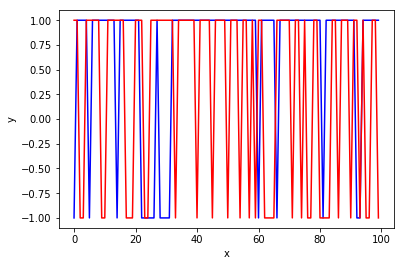

In [46]:
ax = plt.gca()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot([idx for idx in range(0,100)],predict_y[:100],c='blue')
ax.plot([idx for idx in range(0,100)],test_y[:100] ,c='red')
plt.show()

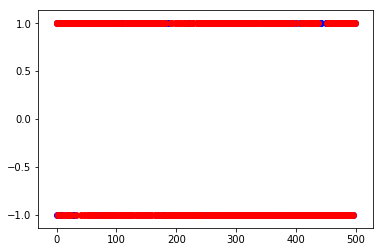

In [47]:
plt.scatter([idx for idx in range(0,500)],predict_y[:500],c='blue')
plt.scatter([idx for idx in range(0,500)],test_y[:500] ,c='red')
plt.show()

In [55]:
# print('准确率：',accuracy_scores/10)
# print('召回率：',recall_scores/10)
# print('精确率：',precision_scores/10)
# print('F-measure：',f1_scores/10)

In [48]:
## 聚类
from sklearn.cluster import KMeans
n = 100
cluster = []
for i in range(0,n):
    cluster.append(set())
for i in range(n):
    cluster.append(set())
tokens = []
for data in datas:
    for ts in data['tokens']:
        tokens.append(ts)
model = Word2Vec(sentences = tokens,min_count = 10)
vectors = {}
for v in model.wv.vocab.keys():
    if v in feature_words and len(v)>2:
        vectors[v] = model[v]
labels = KMeans(n_clusters=n, random_state=9).fit_predict([vector for vector in vectors.values()])

for i in range(0,len(labels)):
    cluster[labels[i]].add(list(vectors.keys())[i])
for c in cluster:
    if len(c) != 0:
        print(c)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


{'cancer', 'drug'}
{'control', 'majority', 'shareholder'}
{'time', 'supply', 'round', 'sign', 'effect', 'move', 'action'}
{'research'}
{'steel', 'copper', 'aluminum', 'tariff', 'import'}
{'officer', 'executive'}
{'cash', 'bid', 'offer', 'pay', 'acquisition', 'sale'}
{'gauge'}
{'portfolio', 'manager'}
{'week', 'month', 'year'}
{'investigation', 'official', 'security', 'agency', 'law', 'regulator', 'rule', 'state', 'court', 'case', 'country', 'office', 'budget', 'government'}
{'strategist'}
{'director', 'head'}
{'home', 'product', 'help', 'network', 'online', 'delivery', 'access', 'use', 'payment', 'customer', 'competition', 'system', 'user', 'service', 'information'}
{'food', 'car', 'auto', 'equipment', 'export', 'power', 'vehicle'}
{'period', 'value', 'target', 'deficit', 'end', 'level', 'start', 'range', 'date', 'volume'}
{'producer', 'brand', 'rival', 'automaker', 'parent', 'chipmaker', 'supplier', 'operator', 'unit', 'com'}
{'loss'}
{'labor', 'wage', 'job'}
{'quarter'}
{'forecast'}
